In [30]:
import os
import glob
import numpy as np
import itertools
import random

from skimage import feature
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
path = 'data/flowers/'

In [32]:
img_width = img_height=128

In [33]:
def resizeImage(img, img_width=128, img_height=128):
    return img.resize((img_width, img_height))

In [34]:
def localBinaryPatterns(image, numPoints=24, radius=2):
    
    lbp = feature.local_binary_pattern(image, numPoints,
                    radius, method="uniform")
    return lbp

In [38]:
def RGB2Gray(image):

    image = np.array(image)
    return np.dot(image[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [35]:
def get_data(path):
    X, y =  [], []
    count = 0
    labels = {}
    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':
            labels[count] = subdir.split('/')[-1]
            path_folder = os.path.join(subdir, '*.jpg')
            filesPath = glob.glob(path_folder) 
            
            for fileName in filesPath:
                img = Image.open(fileName)
                X.append(img)

            y.extend(np.full((1, len(files)), count, dtype=int)[0])
            count+=1
    return (X, y, labels)

In [4]:
X, y, labels = get_data(path)

In [7]:
def showCamaraPhotos(X, y, labels):

    idx = random.randint(0,len(X))

    plt.figure()
    plt.title(labels[y[idx]])
    plt.imshow(X[idx])
    plt.axis('off')

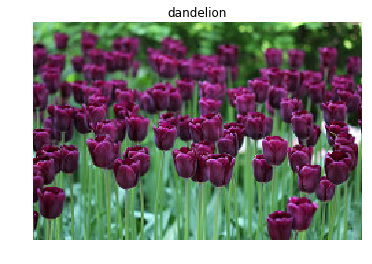

In [8]:
showCamaraPhotos(X, y, labels)

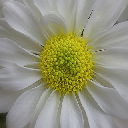

In [21]:
resizeImage(X[0])

In [39]:
def preProcessingDataset(X):
    
    idx = random.randint(0,len(X))
        
    aux = resizeImage(X[idx])
    aux = RGB2Gray(X[idx])
    aux = localBinaryPatterns(aux)
    
    return aux

(-0.5, 499.5, 331.5, -0.5)

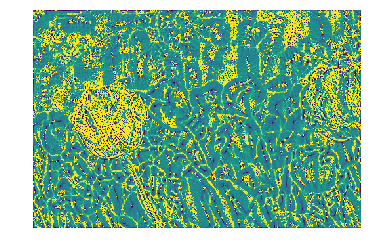

In [42]:
aux = preProcessingDataset(X)
plt.imshow(aux)
plt.axis('off')